### Imports  & Parameters

In [36]:
%load_ext autoreload
%autoreload 2

import os, sys
# ugly workaround for imports
sys.path.append(os.path.split(os.getcwd())[0])
from tqdm import tqdm

import numpy as np
import scipy as sp
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

import matplotlib.pyplot as pl
import matplotlib.animation as animation
%matplotlib inline

from scipy.ndimage.interpolation import rotate

from utils.fit import *
from utils.prf import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# parameters of analysis
n_pix = 25
rsq_threshold = 0.75
cv_fold=3
mask_name = 'V2'

In [38]:
# settings that have to do with the data and experiment
TR = 0.945
screen_distance = 225
screen_width = 39
nr_TRs = 462
timepoints = np.arange(nr_TRs) * TR
extent = [-7.5, 7.5]
stim_radius = 5.0
n_folds = 6

### Get Data

`prf_cv_fold_data` is the prf parameters, 
`rfs` are the pixel-based rf profiles.

data file found, returning local file ../data/V2.h5


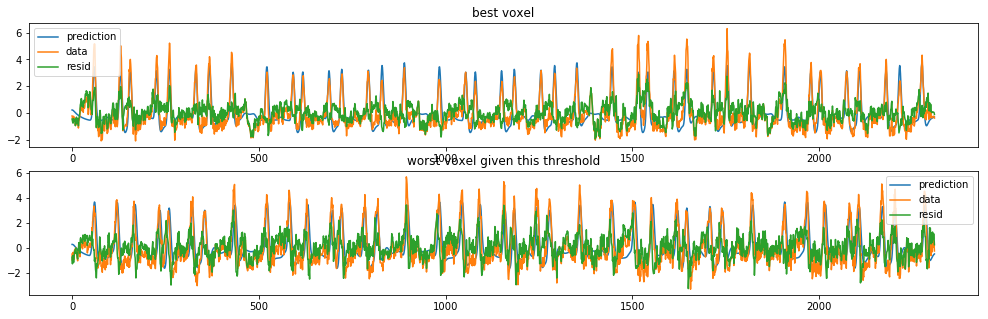

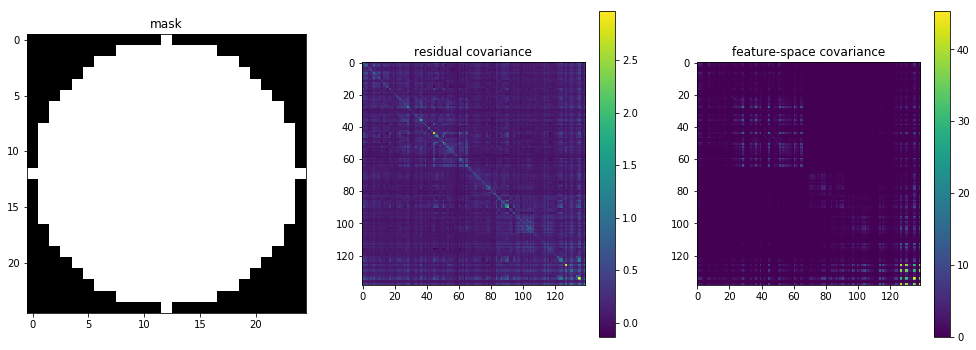

In [52]:
(prf_cv_fold_data, rfs, linear_predictor_ip, 
 all_residuals_css, all_residual_covariance_css, 
 stimulus_covariance_WW, test_data, mask) = setup_data_from_h5(
                        data_file = '../data/%s.h5'%mask_name, 
                        n_pix=n_pix, 
                        extent=extent, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        cv_fold=cv_fold,
                        n_folds=n_folds,
                        use_median=False,
                        mask_name=mask_name)

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(mask, cmap='gray');
s.set_title('mask')
s = f.add_subplot(132)
pl.imshow(all_residual_covariance_css)
s.set_title('residual covariance')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(stimulus_covariance_WW)
s.set_title('feature-space covariance')
pl.colorbar();

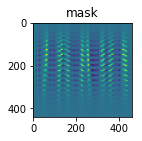

In [53]:
f = pl.figure(figsize=(6,6))
s = f.add_subplot(131)
pl.imshow(linear_predictor, cmap='viridis');
s.set_title('mask')
linear_predictor = np.dot(rfs, test_data)

max tau: 1.15909470927 min tau: 0.0444214320831
sigma: -0.171021668634 rho: 0.527641994877
summed squared distance: 124.831870413


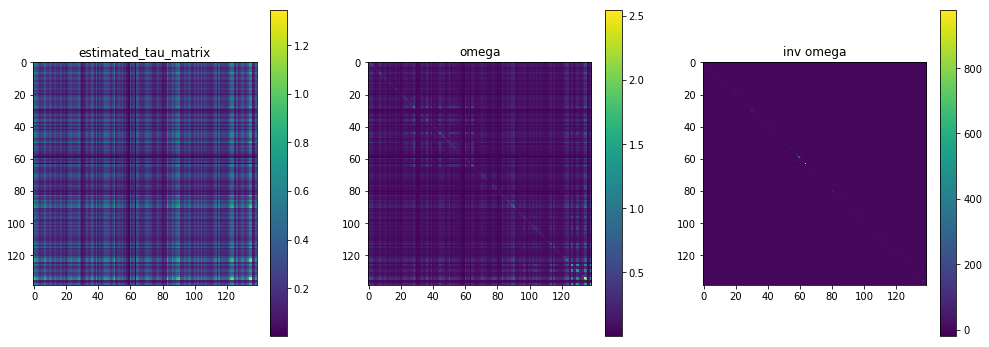

In [54]:
# estimate the covariance structure, which outputs all parameters
(estimated_tau_matrix, estimated_rho, 
 estimated_sigma, omega, 
 omega_inv, logdet) = fit_model_omega(
                                        observed_residual_covariance=all_residual_covariance_css, 
                                        featurespace_covariance=stimulus_covariance_WW,
                                        verbose=1
                                        )

f = pl.figure(figsize=(17,6))
s = f.add_subplot(131)
pl.imshow(estimated_tau_matrix)
s.set_title('estimated_tau_matrix')
pl.colorbar()
s = f.add_subplot(132)
pl.imshow(omega)
s.set_title('omega')
pl.colorbar()
s = f.add_subplot(133)
pl.imshow(omega_inv)
s.set_title('inv omega')
pl.colorbar();

In [55]:
# set up result array:
dm_pixel_logl_ratio = np.zeros((mask.sum(),test_data.shape[1]))

# and loop across timepoints
for t, bold in enumerate(test_data.T):
    dm_pixel_logl_ratio[:,t] = firstpass_decoder_independent_Ws(
                                        bold=bold, 
                                        logdet=logdet,
                                        omega_inv=omega_inv,
                                        linear_predictor_ip=linear_predictor_ip)

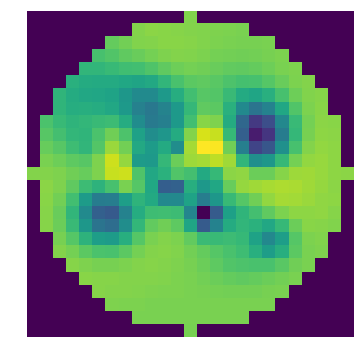

In [56]:
from IPython.display import HTML

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(dm_pixel_logl_ratio.shape[1]):
    stim_2d_array = np.zeros(mask.shape)
    stim_2d_array[mask] = dm_pixel_logl_ratio[:,t]
    im = pl.imshow(stim_2d_array/stim_2d_array.sum(), animated=True, cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)
ani
# HTML(ani.to_html5_video())
# ani.save('out.mp4', fps=30, extra_args=['-vcodec', 'libx264'], writer=animation.FFMpegFileWriter())

In [8]:
# decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
# for t, bold in enumerate(test_data.T):
#     decoded_image[:,t] = maximize_loglikelihood(
#                                         starting_value=dm_pixel_logl_ratio[:,t],
#                                         bold=bold,
#                                         logdet=logdet,
#                                         omega_inv=omega_inv,
#                                         rfs=rfs, 
#                                         prf_data=prf_cv_fold_data)
    

In [58]:
decoded_image = np.zeros((mask.sum(),test_data.shape[1]))  
for t, bold in enumerate(tqdm(test_data.T)):
    
    starting_value=dm_pixel_logl_ratio[:,t]
    prf_data=prf_cv_fold_data
    bnds=[(0,1) for elem in rfs]


    final_result=sp.optimize.minimize(
                                    calculate_bold_loglikelihood, 
                                    starting_value, 
                                    args=(  rfs,
                                            prf_data, 
                                            logdet, 
                                            omega_inv, 
                                            bold), 
                                    method='L-BFGS-B', 
                                    bounds=bnds,
                                    tol=1e-01,
                                    options={'disp':False})
    decoded_image[:,t] = final_result.x
    logl = -final_result.fun

100%|██████████| 462/462 [00:17<00:00, 28.93it/s]


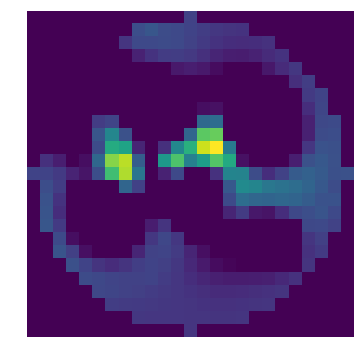

In [59]:
recon = np.zeros([decoded_image.shape[1]]+list(mask.shape) )

fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(decoded_image.shape[1]):
    recon[t,mask] = decoded_image[:,t]

    im = pl.imshow(recon[t]/recon[t].sum(), animated=True, cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani

In [60]:
thetas = [-1, 0, -1, 45, 270, -1,  315,  180, -1,  135,   90, -1,  225, -1]
rotated_recon = np.copy(recon).T

hrf_delay = 0
block_delimiters = np.r_[np.arange(2, 462, 34) + hrf_delay, 462]
reshrot_recon = np.zeros((8, rotated_recon.shape[0], rotated_recon.shape[1], 38))
bar_counter = 0
for i in range(len(block_delimiters) - 1):
    if thetas[i] != -1:
        rotated_recon[:, :, block_delimiters[i]:block_delimiters[i + 1] + 4] = rotate(rotated_recon[:, :, block_delimiters[i]:block_delimiters[i + 1] + 4],
                                                                                      axes=(
            0, 1),
            angle=thetas[i],
            reshape=False,
            mode='nearest')
        reshrot_recon[bar_counter] = rotated_recon[:, :,
                                                   block_delimiters[i]:block_delimiters[i + 1] + 4]
        bar_counter += 1

reshrot_recon_m = np.median(reshrot_recon, axis=0)

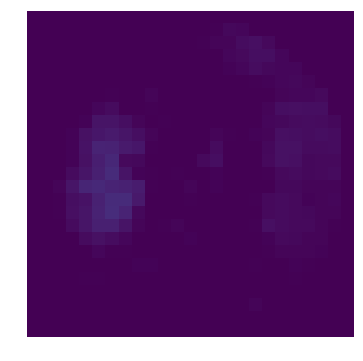

In [61]:
fig = pl.figure(figsize=(6, 6))
ims = []

for t in range(reshrot_recon_m.shape[-1]):
    im = pl.imshow(reshrot_recon_m[...,t], animated=True, clim=[0,1], cmap='viridis')
    pl.axis('off')
    ims.append([im])

ani = animation.ArtistAnimation(
    fig, ims, interval=150, blit=True, repeat_delay=1500)

ani

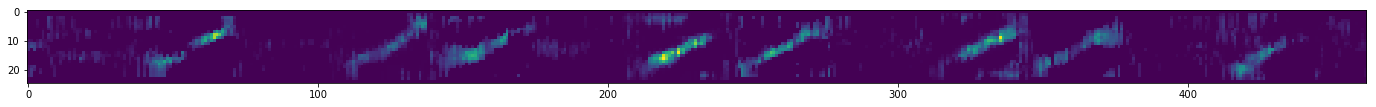

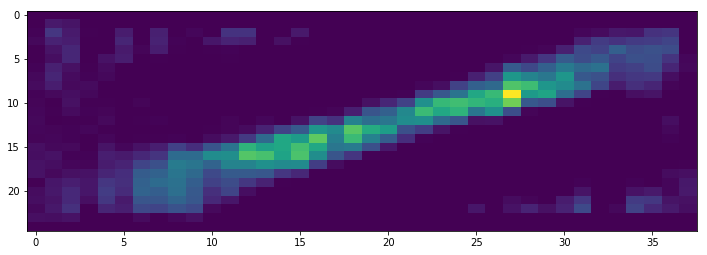

In [62]:
pl.figure(figsize=(24,7))
pl.imshow(np.median(rotated_recon, axis = 0));
pl.figure(figsize=(12,6))
pl.imshow(np.median(reshrot_recon_m, axis = 0), aspect = 0.5);

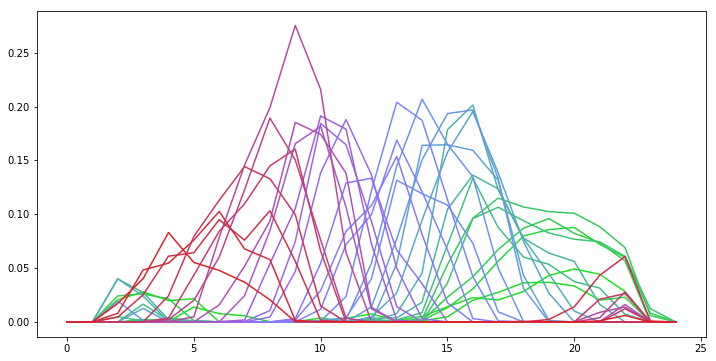

In [63]:
pl.figure(figsize=(12,6))
for t in np.arange(4,np.median(reshrot_recon_m, axis = 0).shape[1]-4):
    pl.plot(np.median(reshrot_recon_m, axis = 0)[:,t], color = (t/38, (1-t/38),0.5+-np.cos(2*np.pi*t/38)/2));

### CV across folds...

  0%|          | 0/6 [00:00<?, ?it/s]

data file found, returning local file ../data/V1.h5
max tau: 38.2170756891 min tau: -0.00215934210252
sigma: 14.1336106938 rho: 0.167829920305
summed squared distance: 1519914.67172


 17%|█▋        | 1/6 [03:13<16:06, 193.33s/it]

data file found, returning local file ../data/V1.h5
max tau: 39.0639777288 min tau: -0.213701958216
sigma: 12.6476771167 rho: 0.165775761651
summed squared distance: 1658533.97409


 33%|███▎      | 2/6 [06:35<13:03, 195.84s/it]

data file found, returning local file ../data/V1.h5
max tau: 37.0157773711 min tau: -0.485180502235
sigma: 14.1381058418 rho: 0.173906992165
summed squared distance: 1326840.34981


 50%|█████     | 3/6 [09:46<09:43, 194.54s/it]

data file found, returning local file ../data/V1.h5
max tau: 38.464884977 min tau: 0.129508831652
sigma: 13.775767158 rho: 0.16372686231
summed squared distance: 1555138.8006


 67%|██████▋   | 4/6 [13:06<06:32, 196.13s/it]

data file found, returning local file ../data/V1.h5
max tau: 28.5216199533 min tau: 0.244711848958
sigma: 12.8721013506 rho: 0.15043774039
summed squared distance: 636333.680988


 83%|████████▎ | 5/6 [16:23<03:16, 196.42s/it]

data file found, returning local file ../data/V1.h5
max tau: 38.0631518022 min tau: -0.0583519319376
sigma: 12.7482040052 rho: 0.166237703102
summed squared distance: 1519880.4746


100%|██████████| 6/6 [19:35<00:00, 195.00s/it]


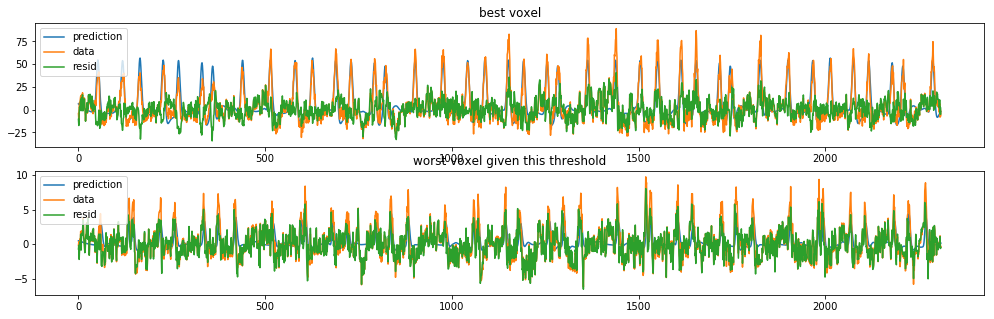

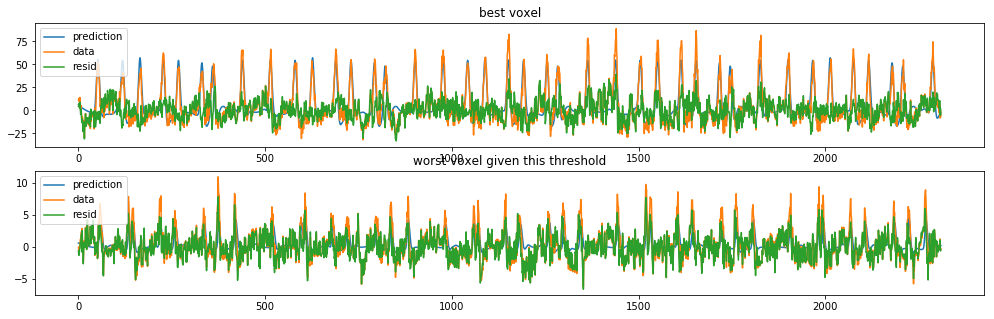

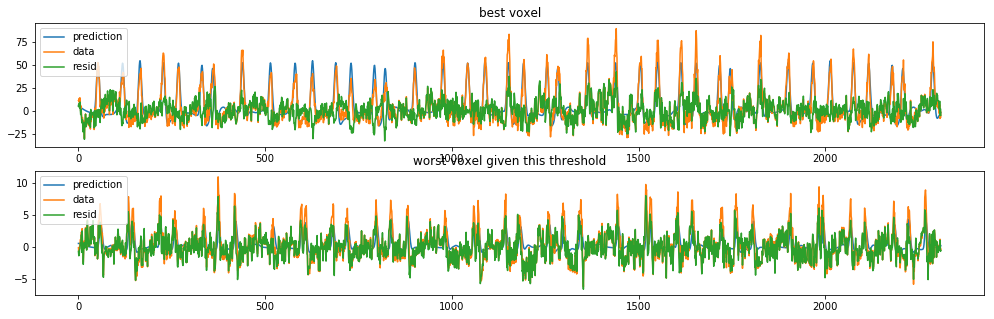

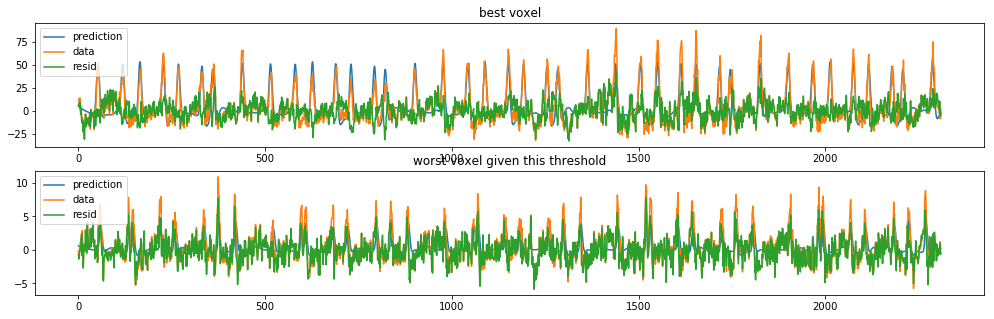

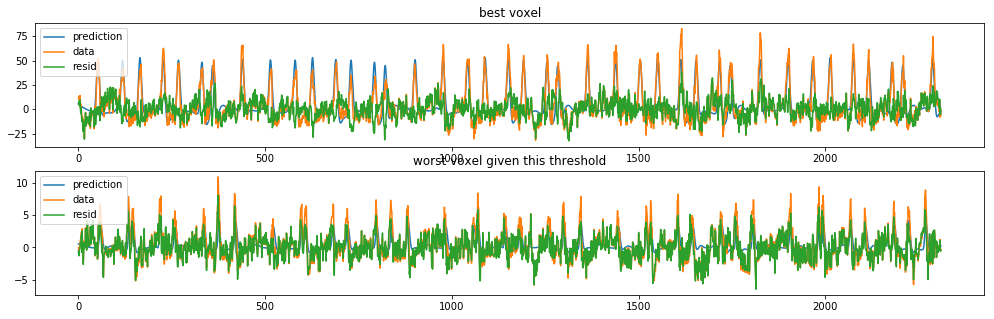

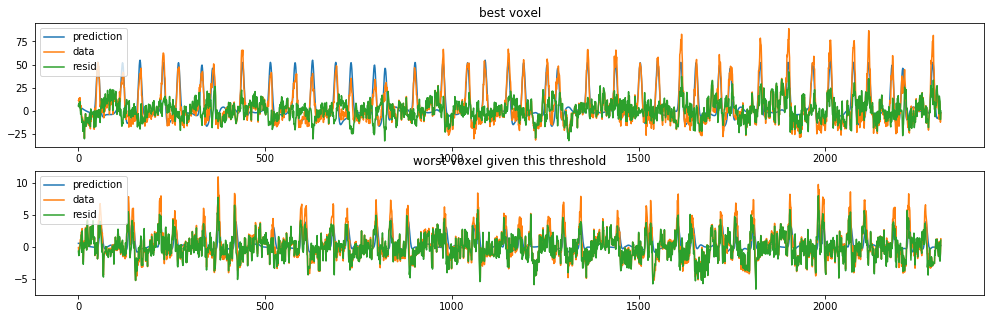

In [37]:
cv_decoded_image, cv_reshrot_recon, cv_reshrot_recon_m, \
cv_omega, cv_estimated_tau_matrix, cv_estimated_rho, \
cv_estimated_sigma = decode_cv_prfs(data_file='../data/%s.h5'%mask_name, 
                        n_pix=n_pix, 
                        extent=extent, 
                        screen_distance=screen_distance, 
                        screen_width=screen_width, 
                        rsq_threshold=rsq_threshold,
                        TR=TR,
                        cv_fold=cv_fold,
                        n_folds=n_folds,
                        use_median=False,
                        mask_name=mask_name)

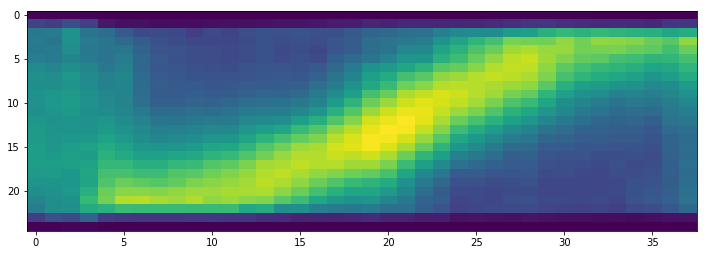

In [27]:
pl.figure(figsize=(12,6))
path = np.median(np.median(cv_reshrot_recon_m, axis=0), axis=0)
pl.imshow(path, aspect = 0.5);

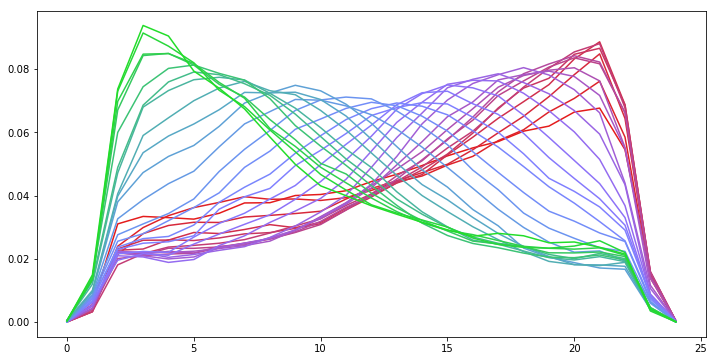

In [32]:
pl.figure(figsize=(12,6))
m_cv_rr = np.median(np.median(cv_reshrot_recon_m, axis=0), axis=0)
for t in np.arange(4,m_cv_rr.shape[1]-4):
    pl.plot(m_cv_rr[:,t]/np.sum(m_cv_rr[:,t]), color = ((1-t/38), t/38, 0.5+-np.cos(2*np.pi*t/38)/2));